In [1]:
import sys
sys.path.append('../')

%load_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np
import cv2

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.io import imread

from gen.load_data import load_data

from keras.optimizers import Adam
import keras.backend as K


/home/faisal/anaconda3/envs/ai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.utils import shuffle

train_df, valid_df, test_df = load_data('../data')

train_df = shuffle(train_df)
valid_df = shuffle(valid_df)

print(train_df.head())


                                                image                   id  \
198                   ../data/Train/CameraRGB/185.png                  185   
1033                  ../data/Train/CameraRGB/326.png                  326   
1379  ../data/Train/CameraRGB/episode_0000_000203.png  episode_0000_000203   
257                   ../data/Train/CameraRGB/946.png                  946   
1315                  ../data/Train/CameraRGB/489.png                  489   

                                                label  
198                   ../data/Train/CameraSeg/185.png  
1033                  ../data/Train/CameraSeg/326.png  
1379  ../data/Train/CameraSeg/episode_0000_000203.png  
257                   ../data/Train/CameraSeg/946.png  
1315                  ../data/Train/CameraSeg/489.png  


In [4]:
from models.unet import model_unet
from models.fcn8 import model_fcn8
from models.segnet import model_segnet

model = model_segnet(3, image_shape=(480, 480, 3))
model.summary()

Build enceder done..
Build decoder done..
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 480, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 480, 480, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 480, 480, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 480, 480, 64) 0           batch_normalization_1[0][0]      
___________________________________________________________________

In [5]:
from gen.generators import train_and_lab_gen_func

BATCH_SIZE = 8

train_gen = train_and_lab_gen_func(train_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)
valid_gen = train_and_lab_gen_func(valid_df, image_size=(600, 800), target_size=(480, 480), batch_size = BATCH_SIZE)
# test_gen = train_and_lab_gen_func(test_df, image_size=(600, 800),  target_size=(480, 480),  batch_size = BATCH_SIZE)

In [6]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss


In [7]:
from train import jaccard_distance_loss
from keras.optimizers import SGD, rmsprop

# opt =SGD(lr=1, momentum=0.01, decay=0.001, nesterov=False)
opt = rmsprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
weights = np.array([10, 5, 1])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model.compile(optimizer = opt, 
#                    loss = jaccard_distance_loss,
#                    metrics = ['acc'])


## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2500 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2500 images


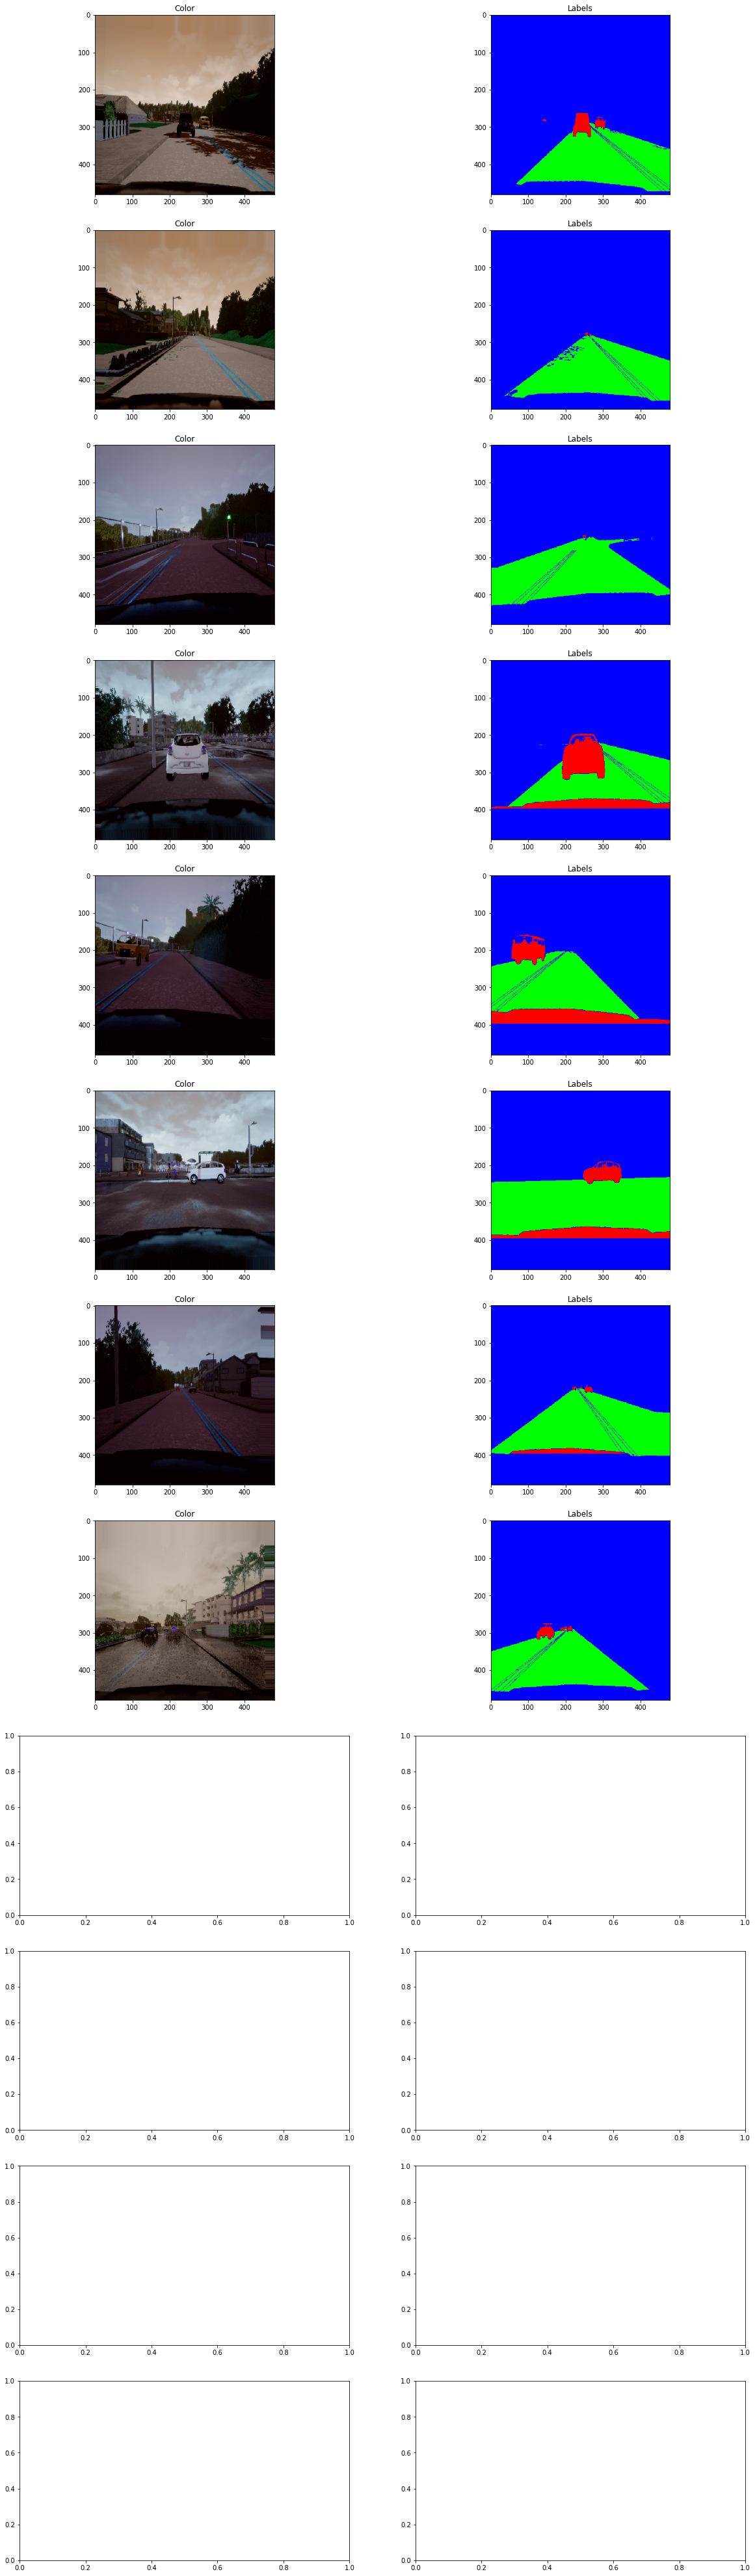

In [8]:
train_x, train_y = next(train_gen)

sample_rows = 12
fig, m_axs = plt.subplots(sample_rows, 2, figsize = (20, 6*sample_rows))
# [c_ax.axis('off') for c_ax in m_axs.flatten()]
for (ax1, ax2), rgb_img, lab_img in zip(m_axs, train_x, train_y):
    # undoing the vgg correction is tedious
    r_rgb_img = np.clip(rgb_img+110, 0, 255).astype(np.uint8)
    ax1.imshow(r_rgb_img)
    ax1.set_title('Color')
    ax2.imshow(lab_img)
    ax2.set_title('Labels')

In [9]:
X = np.expand_dims(train_x[3], 0)
Y = np.expand_dims(train_y[3], 0)
print (X.shape, Y.shape)

# model.reset_states()
history = model.fit(X, Y, epochs=300)

(1, 480, 480, 3) (1, 480, 480, 3)
Epoch 1/300
1/1 [==============================] - 4s 4s/step - loss: 1.3764 - acc: 0.3588
Epoch 2/300
1/1 [==============================] - 0s 208ms/step - loss: 1.2666 - acc: 0.2876
Epoch 3/300
1/1 [==============================] - 0s 197ms/step - loss: 1.1834 - acc: 0.3156
Epoch 4/300
1/1 [==============================] - 0s 206ms/step - loss: 1.1435 - acc: 0.3228
Epoch 5/300
1/1 [==============================] - 0s 201ms/step - loss: 1.1230 - acc: 0.3165
Epoch 6/300
1/1 [==============================] - 0s 203ms/step - loss: 1.1117 - acc: 0.3267
Epoch 7/300
1/1 [==============================] - 0s 201ms/step - loss: 1.1047 - acc: 0.3399
Epoch 8/300
1/1 [==============================] - 0s 203ms/step - loss: 1.0995 - acc: 0.3522
Epoch 9/300
1/1 [==============================] - 0s 198ms/step - loss: 1.0942 - acc: 0.3613
Epoch 10/300
1/1 [==============================] - 0s 204ms/step - loss: 1.0885 - acc: 0.3604
Epoch 11/300
1/1 [==========

1/1 [==============================] - 0s 203ms/step - loss: 0.4210 - acc: 0.9825
Epoch 88/300
1/1 [==============================] - 0s 199ms/step - loss: 0.4197 - acc: 0.9804
Epoch 89/300
1/1 [==============================] - 0s 198ms/step - loss: 0.4167 - acc: 0.9813
Epoch 90/300
1/1 [==============================] - 0s 200ms/step - loss: 0.4160 - acc: 0.9837
Epoch 91/300
1/1 [==============================] - 0s 200ms/step - loss: 0.4131 - acc: 0.9837
Epoch 92/300
1/1 [==============================] - 0s 198ms/step - loss: 0.4125 - acc: 0.9816
Epoch 93/300
1/1 [==============================] - 0s 203ms/step - loss: 0.4098 - acc: 0.9836
Epoch 94/300
1/1 [==============================] - 0s 201ms/step - loss: 0.4089 - acc: 0.9852
Epoch 95/300
1/1 [==============================] - 0s 201ms/step - loss: 0.4072 - acc: 0.9841
Epoch 96/300
1/1 [==============================] - 0s 200ms/step - loss: 0.4054 - acc: 0.9840
Epoch 97/300
1/1 [==============================] - 0s 204ms/st

Epoch 173/300
1/1 [==============================] - 0s 201ms/step - loss: 0.3266 - acc: 0.9923
Epoch 174/300
1/1 [==============================] - 0s 199ms/step - loss: 0.3258 - acc: 0.9908
Epoch 175/300
1/1 [==============================] - 0s 202ms/step - loss: 0.3250 - acc: 0.9923
Epoch 176/300
1/1 [==============================] - 0s 201ms/step - loss: 0.3240 - acc: 0.9916
Epoch 177/300
1/1 [==============================] - 0s 204ms/step - loss: 0.3232 - acc: 0.9916
Epoch 178/300
1/1 [==============================] - 0s 209ms/step - loss: 0.3225 - acc: 0.9923
Epoch 179/300
1/1 [==============================] - 0s 204ms/step - loss: 0.3217 - acc: 0.9914
Epoch 180/300
1/1 [==============================] - 0s 205ms/step - loss: 0.3208 - acc: 0.9920
Epoch 181/300
1/1 [==============================] - 0s 204ms/step - loss: 0.3201 - acc: 0.9923
Epoch 182/300
1/1 [==============================] - 0s 198ms/step - loss: 0.3194 - acc: 0.9916
Epoch 183/300
1/1 [=====================

Epoch 259/300
1/1 [==============================] - 0s 224ms/step - loss: 0.2711 - acc: 0.9927
Epoch 260/300
1/1 [==============================] - 0s 212ms/step - loss: 0.2707 - acc: 0.9939
Epoch 261/300
1/1 [==============================] - 0s 200ms/step - loss: 0.2700 - acc: 0.9946
Epoch 262/300
1/1 [==============================] - 0s 209ms/step - loss: 0.2694 - acc: 0.9928
Epoch 263/300
1/1 [==============================] - 0s 200ms/step - loss: 0.2686 - acc: 0.9935
Epoch 264/300
1/1 [==============================] - 0s 208ms/step - loss: 0.2679 - acc: 0.9943
Epoch 265/300
1/1 [==============================] - 0s 200ms/step - loss: 0.2676 - acc: 0.9936
Epoch 266/300
1/1 [==============================] - 0s 197ms/step - loss: 0.2668 - acc: 0.9944
Epoch 267/300
1/1 [==============================] - 0s 202ms/step - loss: 0.2660 - acc: 0.9946
Epoch 268/300
1/1 [==============================] - 0s 207ms/step - loss: 0.2654 - acc: 0.9939
Epoch 269/300
1/1 [=====================

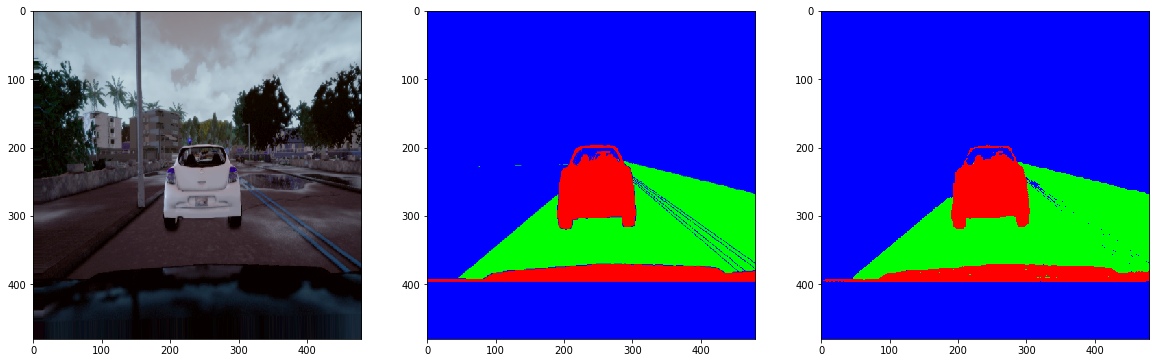

In [10]:
pred = model.predict(X)
pred = pred[0].argmax(axis=2)
pred_out = np.zeros_like(Y[0])
pred_out[:, :, 0] = pred == 0
pred_out[:, :, 1] = pred == 1
pred_out[:, :, 2] = pred == 2

plt.figure(figsize=(20, 20))
plt.subplot(131)
plt.imshow(np.clip(X[0]+110, 0, 255).astype(np.uint8))
plt.subplot(132)
plt.imshow(Y[0])
plt.subplot(133)
plt.imshow(pred_out)

In [ ]:
# # summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
plt.show()